In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from datetime import datetime, timedelta
from jacobi_eigenvalues import jacobi_eigenvalues

In [4]:
# Data loading and pre-processing
daily_yields = pd.read_csv("daily_i_par_curve.csv", index_col='date',  parse_dates=True)

daily_yields_numpy = daily_yields.to_numpy()

maturities = daily_yields.columns.astype(int).tolist()
dates = daily_yields.index.tolist()
daily_yields.head()

,0,3,6,9,12,15,18,21,24,27,...,333,336,339,342,345,348,351,354,357,360
date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,1.609854,2.0,6.0,9.261816,12.0,15.291309,19.098722,23.106774,27.0,30.539258,...,309.254851,308.718680,308.014398,307.137513,306.083533,304.847966,303.426321,301.814107,300.006830,298.0
2012-01-04,1.590062,2.0,6.0,9.338510,12.0,14.844428,17.997668,21.402074,25.0,28.731082,...,314.975511,314.398604,313.644419,312.708180,311.585106,310.270421,308.759346,307.047103,305.128914,303.0
2012-01-05,2.294893,2.0,7.0,9.632289,11.0,13.730255,17.780404,22.440350,27.0,30.904981,...,317.917833,317.343809,316.593286,315.661531,314.543809,313.235386,311.731528,310.027501,308.118570,306.0
2012-01-06,3.063148,2.0,5.0,8.580300,12.0,15.235492,18.390382,21.600081,25.0,28.675391,...,314.032725,313.450713,312.691090,311.749087,310.619933,309.298861,307.781101,306.061883,304.136439,302.0
2012-01-09,2.682101,1.0,5.0,8.331858,11.0,14.270997,18.105345,22.137020,26.0,29.415066,...,313.401529,312.863395,312.153767,311.268067,310.201717,308.950141,307.508758,305.872993,304.038266,302.0


## Eigenvalues 1: With functions

In [5]:
# Computing the principal components with numpy functions

scaler = StandardScaler(with_std=False)
# Scaling the data 
daily_yields_scaled = scaler.fit_transform(daily_yields_numpy)
# Covariance matrix 
V = np.cov(daily_yields_scaled, rowvar = False) # or daily_yields_scaled.T

# Calulation of the eigenvalues & eigenvectors
eigen_values, eigen_vectors = np.linalg.eig(V)
eigen_values = eigen_values.real
eigen_vectors = eigen_vectors.real
# The numpy function linalg.eig return imaginary values however,
# the covariance matrix is symetrical with real values so its eigenvalues are real

## Eigenvalues 2: From scratch

In [6]:
# Numpy scaling and covariance matrix
mean = np.mean(daily_yields_numpy, axis=0)
daily_yields_numpy_scaled = daily_yields_numpy - mean
N = len(daily_yields_numpy)
cov_matrix_numpy = np.dot(daily_yields_numpy_scaled.T, daily_yields_numpy_scaled) / (N-1)


In [7]:
# Compute the eigenvalues and eigenvectors using Jacobi method
eigen_values, eigen_vectors = jacobi_eigenvalues(cov_matrix_numpy)

In [8]:
# Sorting by decreasing ordrer the eigenvalue & eigenvector

eigen_vectors = eigen_vectors.T
idxs = np.argsort(eigen_values)[::-1]
eigen_values = eigen_values[idxs]
eigen_vectors = eigen_vectors[idxs]


In [9]:
# We keep the first 3 components
n_components = 3
eig_vecs = eigen_vectors[0:n_components].T
eig_vecs[:,2] = -1 * eig_vecs[:,2]

Text(0.5, 1.0, 'First 3 PCs across US treasury tenors')

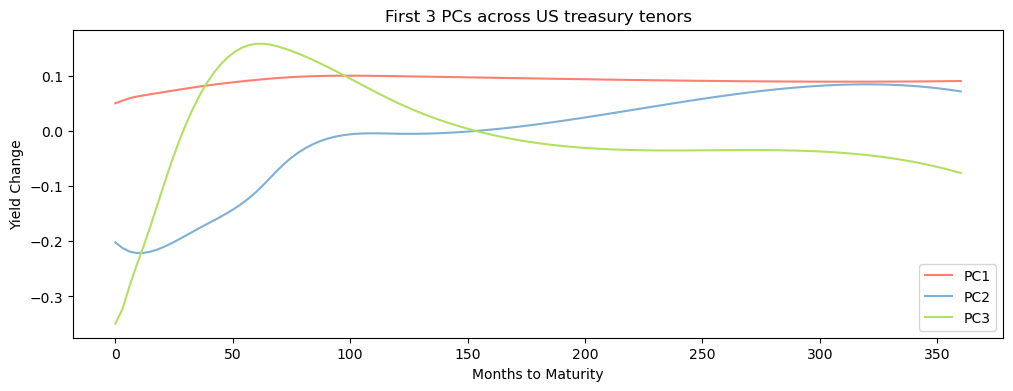

In [10]:
# Plot the principal components 

fig, ax = plt.subplots(1,1,figsize=(12,4))
colors = ["#fd7f6f", "#7eb0d5", "#b2e061"]

for i in range(n_components):
    ax.plot(maturities, eig_vecs[:, i], color = colors[i])
    
ax.set_xlabel("Months to Maturity")
ax.set_ylabel("Yield Change")
ax.legend(["PC1", "PC2", "PC3"])
ax.set_title("First 3 PCs across US treasury tenors")


In [11]:
# Standard deviation, Proportion of explained variance 
# and cumulative proportion of explained variance

std_pc = eig_vecs.std(axis=0)
sum_eigenValues = np.sum(eigen_values)
prop = [eigen_values[0]/sum_eigenValues, eigen_values[1]/sum_eigenValues, eigen_values[2]/sum_eigenValues]
prop = [i*100 for i in prop]

var_explained = {
    "Lines" : ["Standard Deviation", "Proportion of Variance", "Cumulative Proportion (%)"],
    "Component 1" : [std_pc[0], prop[0], prop[0]],
    "Component 2" : [std_pc[1], prop[1], prop[0]+prop[1]],
    "Component 3" : [std_pc[2], prop[2], np.sum(prop)]
}

var_explained = pd.DataFrame(var_explained)
var_explained.set_index(["Lines"], inplace=True)
var_explained.index.name = None
var_explained = var_explained.round(4)
var_explained.head()

,Component 1,Component 2,Component 3
Standard Deviation,0.0093,0.0907,0.0907
Proportion of Variance,77.2856,21.1236,1.2778
Cumulative Proportion (%),77.2856,98.4092,99.6870


## Butterfly Trades

In [12]:
# PCA on rolling windows
def pca_rolling(nyear, m1, m2, m3, daily_yields):
    n = int(251 * nyear) # Window length
    results = [] # np.zeros(())

    # Compute desired maturities 

    # m1, m2, m3 = 24, 60, 120
    yields_butterfly = daily_yields.loc[:,[str(m1),str(m2),str(m3)]]    

    for i in range(n, len(yields_butterfly)):
        yields_windowed = yields_butterfly.iloc[i-n:i,:]
        pca_butterfly = PCA(n_components=3)
        pca_butterfly.fit(yields_windowed)
        results.append(pca_butterfly.components_[2])

    pca_results = pd.DataFrame(results, columns=yields_butterfly.columns, index=daily_yields.iloc[n:,:].index)
    pca_results.head()

    # Normalize by belly
    weights = pca_results.div(pca_results[str(m2)], axis=0)

    yields_butterfly = yields_butterfly.iloc[n:,:]
    fly = (yields_butterfly * weights).sum(axis=1)
    return yields_butterfly, weights, fly

2016-01-07 00:00:00


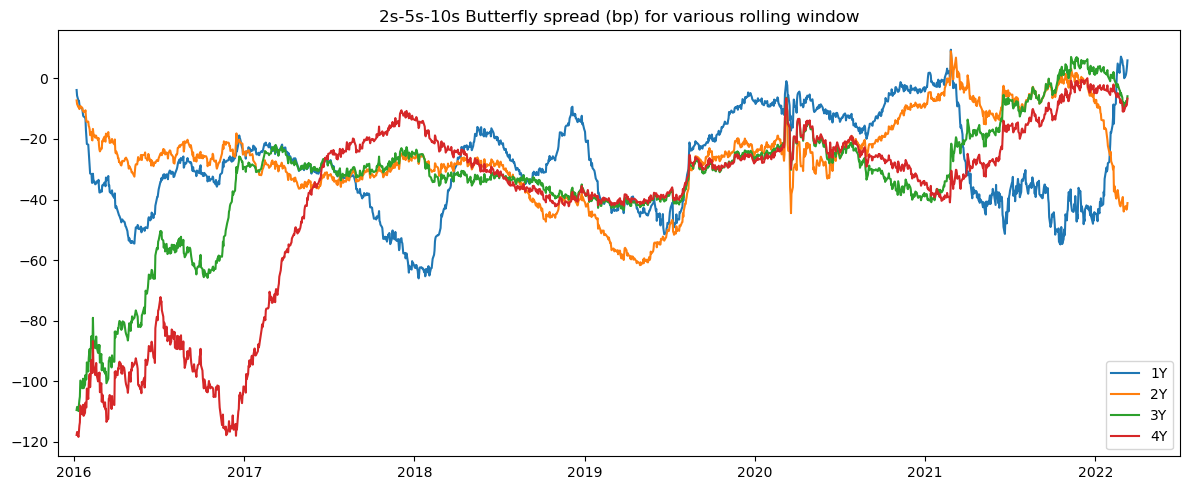

In [13]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
for i in range(1,5):
    yields_butterfly, weights, fly = pca_rolling(i, 24, 60, 120, daily_yields)
    ax.plot(fly.loc["2016-01-07 00:00:00":])

ax.set_xlim(left=fly.index[0] - timedelta(days=40))
print(fly.index[0])
ax.set_title("2s-5s-10s Butterfly spread (bp) for various rolling window")
ax.legend(["1Y", "2Y", "3Y", "4Y"])
fig.tight_layout()
plt.show()

## Further Analysis of the Principal Components

In [14]:
scaler = StandardScaler()
daily_yields_scaled = scaler.fit_transform(daily_yields_numpy)
proj = daily_yields_scaled.dot(eig_vecs)
proj.shape

(2550, 3)

### Observations in the principal components space

Usually, a way to find a relation between the PCs and observations is to plot them into the Pcs space to see how the observations are located, in our case it seems that no obvious pattern can be found 

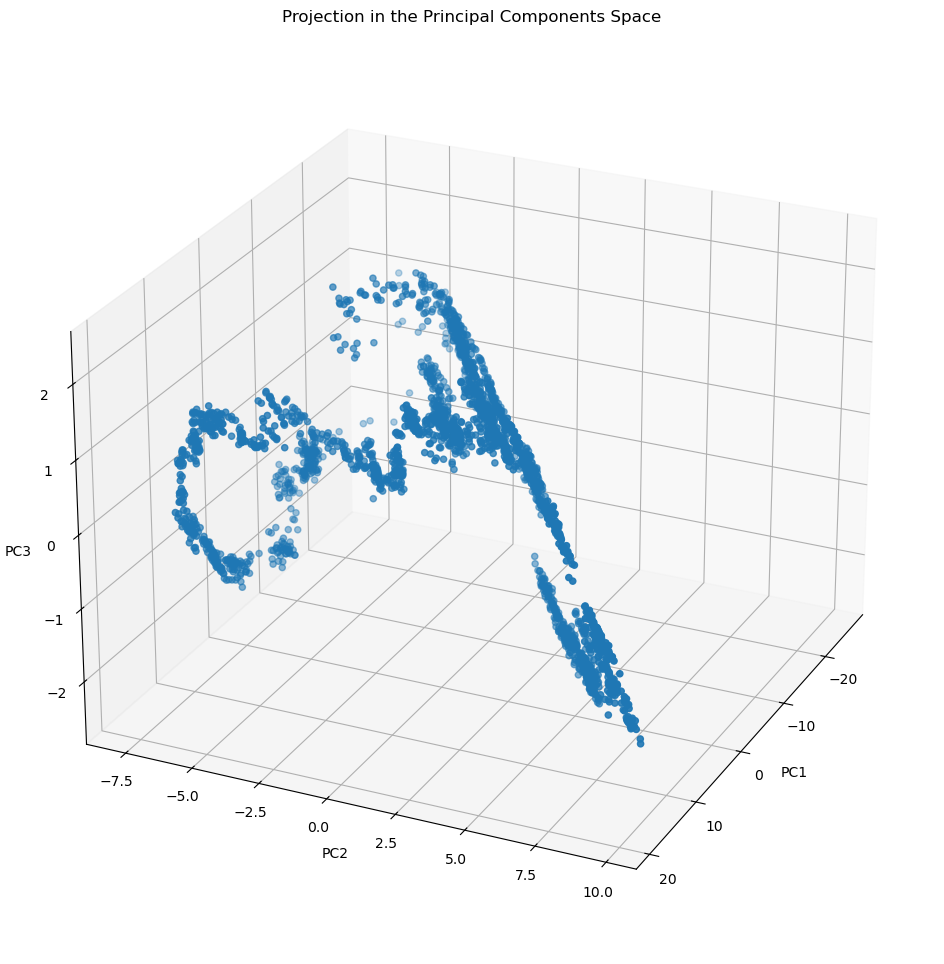

In [26]:
# To find a pattern in the data we can try to plot the data in
# the eigenvalues space

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
colors = ["#fd7f6f", "#7eb0d5", "#b2e061"]

ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2])
ax.set_title("Projection in the Principal Components Space")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.view_init(azim=25, elev=25)

### Contributions

Another interesting way to interpret the data is to plot the contribution of each observation to one PC:

In [16]:
# Then let's look at the contribution of each observation

proj1 = proj[:,0]
n_ind = len(proj1)
contrib = np.zeros(n_ind)
for i in range(n_ind):
    contrib[i] = proj1[i]**2 / (eigen_values[0] * n_ind)
contrib = contrib / np.sum(contrib) * 100


In [17]:
inflation = pd.read_csv("united-states-inflation-rate-cpi.csv", index_col='date',  parse_dates=True)
inflation_dates = inflation.index.to_list()
inflation = inflation[" Inflation Rate (%)"]

In [18]:
interest_rate = pd.read_csv("FEDFUNDS.csv", index_col="DATE", parse_dates=True)

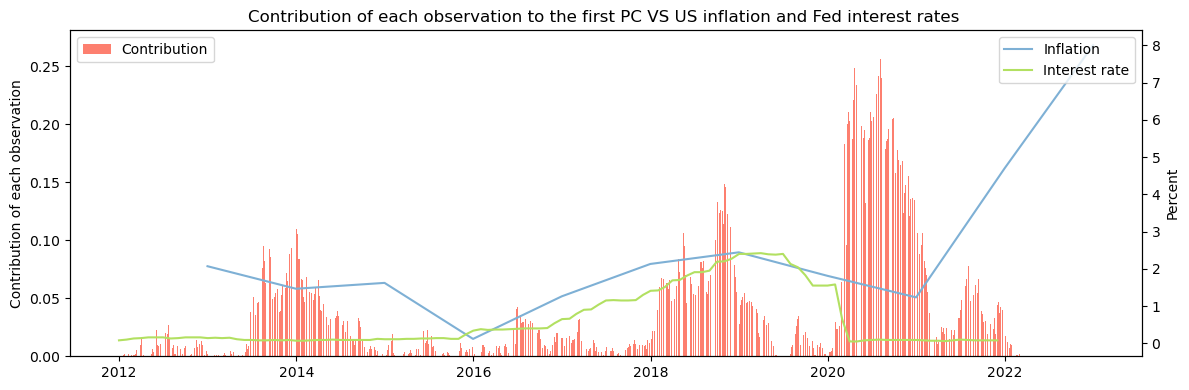

In [19]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
X_values = np.linspace(0, n_ind, n_ind)

ax.bar(dates, contrib, color = colors[0])
ax1 = ax.twinx()
ax1.plot(inflation_dates, inflation, colors[1])
interest_rate.plot(ax=ax1, color=colors[2], legend=False)

ax.set_ylabel("Contribution of each observation")
ax.legend(["Contribution"], loc="upper left")
ax1.set_ylabel("Percent")
ax.set_title("Contribution of each observation to the first PC VS US inflation and Fed interest rates ")
ax1.legend([ "Inflation", "Interest rate"], loc="upper right")
fig.tight_layout()

To analyse the data, I added the inflation rate and Fed interest rate over time to see potential links. 

The first thing to see is that the covid 19 crisis had a huge impact on the curve, the initial impact was more pronounced on shorter-term maturities but the overall yield curve experienced significant shifts resulting in a higher contribution to the 1st PC.

In [20]:
proj1 = proj[:,1]
n_ind = len(proj1)
contrib = np.zeros(n_ind)
for i in range(n_ind):
    contrib[i] = proj1[i]**2 / (eigen_values[0] * n_ind)
contrib = contrib / np.sum(contrib) * 100


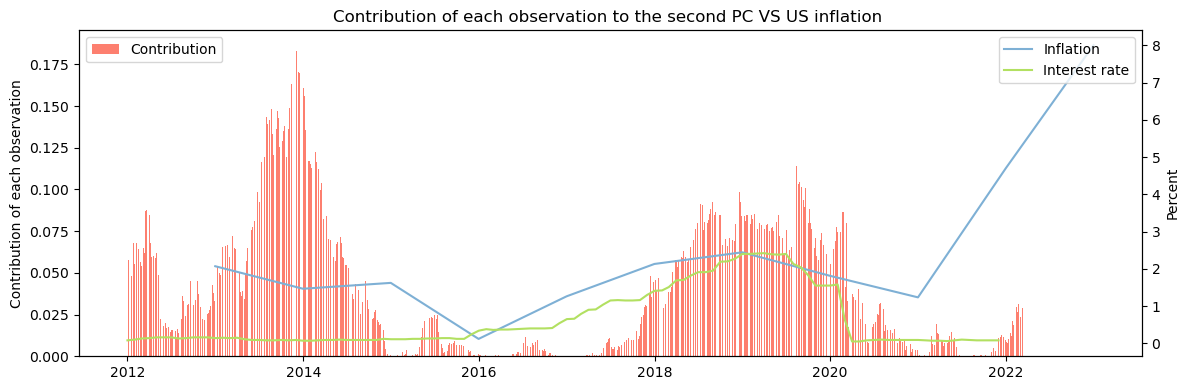

In [21]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
X_values = np.linspace(0, n_ind, n_ind)

ax.bar(dates, contrib, color = colors[0])
ax1 = ax.twinx()
ax1.plot(inflation_dates, inflation, colors[1])
interest_rate.plot(ax=ax1, color=colors[2], legend=False)

ax.set_ylabel("Contribution of each observation")
ax.legend(["Contribution"], loc="upper left")
ax1.set_ylabel("Percent")
ax.set_title("Contribution of each observation to the second PC VS US inflation ")
ax1.legend([ "Inflation", "Interest rate"], loc="upper right")
fig.tight_layout()

For the second PC, the contribution is strong for observations around 2013. \

One interpretation might be that after the subprimes crisis, the Fed decided to launch a policy of Quantitative Easing (QE), it did it 3 times :\
    - In 2008, the fed started buying $600 billion in mortgage-backed securities (MBS) from commercial banks. This action flooded banks with excess liquidity. The excess liquidity put downward influence on short-term interest rates.\
    - In November 2010, the Fed announced a second round of quantitative easing (QE), stating its intention to purchase an additional $600 billion in Treasury securities by the second quarter of 2011.\
    - In September 2011, the Fed announced a strategy to buy and sell short- and long-term bonds to achieve its policy objectives. Known as Operation Twist, this approach aimed to lower long-term interest rates by selling short-term Treasury bonds and purchasing long-term Treasury bonds.\
    - In September 2012, the Fed introduced QE3, an open-ended bond purchasing program involving $40 billion per month in agency mortgage-backed securities (MBS).\

The QE and especially the Operation twist had a huge impact on the slope of yield curve as the fed was buying / selling.
For the third PC, the interpretation seems the same, 

In [22]:
proj1 = proj[:,2]
n_ind = len(proj1)
contrib = np.zeros(n_ind)
for i in range(n_ind):
    contrib[i] = proj1[i]**2 / (eigen_values[0] * n_ind)
contrib = contrib / np.sum(contrib) * 100


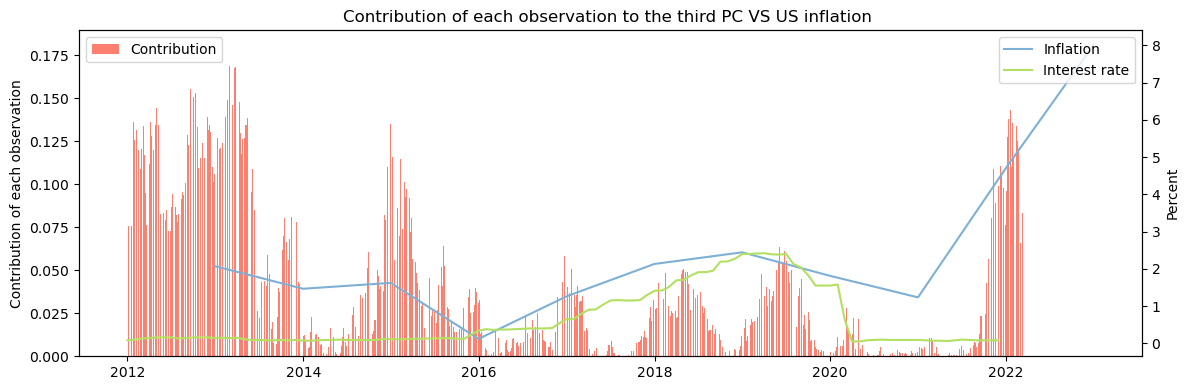

In [23]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
X_values = np.linspace(0, n_ind, n_ind)

ax.bar(dates, contrib, color = colors[0])
ax1 = ax.twinx()
ax1.plot(inflation_dates, inflation, colors[1])
interest_rate.plot(ax=ax1, color=colors[2], legend=False)

ax.set_ylabel("Contribution of each observation")
ax.legend(["Contribution"], loc="upper left")
ax1.set_ylabel("Percent")
ax.set_title("Contribution of each observation to the third PC VS US inflation ")
ax1.legend([ "Inflation", "Interest rate"], loc="upper right")
fig.tight_layout()